In [78]:
import pandas as pd
import numpy as np
import duckdb
from datetime import datetime, date
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:


# Connect to DuckDB. If the database does not exist, it will be created.
con = duckdb.connect(database='transactions.db', read_only=False)

transactions = con.execute("SELECT * FROM transactions").df()
customer = con.execute("SELECT * FROM customers").df()
address = con.execute("SELECT * FROM addresses").df()


# Close the connection
con.close()

In [31]:
df = pd.merge(transactions, customer, left_on='customer_id', right_on='customer_id', how='inner')
df["list_price"].dropna()
df["cost"].dropna()
df['Profit'] = df['list_price']-df['cost']

In [32]:
df['transaction_date']= pd.to_datetime(df['transaction_date'])

C:\Users\thoma\AppData\Local\Temp\ipykernel_5012\423617318.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['transaction_date']= pd.to_datetime(df['transaction_date'])


# RFM Analysis
RFM (Recency, Frequency, Monetary) analysis is a behavior-based approach grouping customers into segments. It groups the customers on the basis of their previous purchase transactions. How recently, how often, and how much did a customer buy. RFM filters customers into various groups for the purpose of better service. There is a segment of customer who is the big spender but what if they purchased only once or how recently they purchased? Do they often purchase our product? Also, It helps managers to run an effective promotional campaign for personalized service.

Recency (R): Who have purchased recently? Number of days since last purchase (least recency)
Frequency (F): Who has purchased frequently? It means the total number of purchases. ( high frequency)
Monetary Value(M): Who have high purchase amount? It means the total money customer spent (high monetary value)

In [33]:
max_trans_date = max(df['transaction_date']).date()

In [34]:
comparison_date = datetime.strptime(str(max_trans_date), "%Y-%m-%d")

In [35]:
# Creating RFM table that will contain recency, frequency and monetary data
rfm_table = df.groupby(['customer_id']).agg({'transaction_date': lambda date : (comparison_date - date.max()).days,
                                                            'product_id' : lambda prod_id : len(prod_id), 
                                                            'Profit' : lambda p : sum(p)})

In [36]:
rfm_table

,transaction_date,product_id,Profit
customer_id,,,
1,7,11,3018.09
2,128,3,2226.26
3,102,8,3362.81
4,195,2,220.57
5,16,6,2394.94
...,...,...,...
3496,256,4,2045.84
3497,52,3,1648.32
3498,127,6,3147.33


In [37]:
rfm_table.rename(columns={'transaction_date' : 'recency', 
                        'product_id' : 'frequency',
                        'Profit' : 'monetary'} , inplace=True)

In [38]:
rfm_table['r_quartile'] = pd.qcut(rfm_table['recency'], 4, ['4','3','2','1'])
rfm_table['f_quartile'] = pd.qcut(rfm_table['frequency'], 4, ['1','2','3','4'])
rfm_table['m_quartile'] = pd.qcut(rfm_table['monetary'], 4, ['1','2','3','4'])


rfm_table = rfm_table.dropna(subset=['m_quartile'])

In [58]:
# Creating RFM metric by prioritising r_quartile > f_quartile > m_quartile
rfm_table['rfm_score'] = 100*rfm_table['r_quartile'].astype(int)+10*rfm_table['f_quartile'].astype(int)+rfm_table['m_quartile'].astype(int)

C:\Users\thoma\AppData\Local\Temp\ipykernel_5012\2777011956.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_table['rfm_score'] = 100*rfm_table['r_quartile'].astype(int)+10*rfm_table['f_quartile'].astype(int)+rfm_table['m_quartile'].astype(int)


In [59]:
rfm_table['customer_title'] = pd.qcut(rfm_table['rfm_score'], 4, ['Bronze','Silver','Gold','Platinum'])

C:\Users\thoma\AppData\Local\Temp\ipykernel_5012\3967022998.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_table['customer_title'] = pd.qcut(rfm_table['rfm_score'], 4, ['Bronze','Silver','Gold','Platinum'])


In [61]:
cust_trans_rfm = pd.merge(df, rfm_table, left_on='customer_id', right_on='customer_id', how='inner')

### Age Group

In [64]:

cust_trans_rfm['Age_Group'] = cust_trans_rfm['age'].apply(lambda x : (math.floor(x/10)+1)*10)

### Tagging customers based on RFM Score

In [66]:
def rfm_title(cols):
    
    rfm_score = cols[0]
    
    if rfm_score >= 444:
        return 'Platinum Customer'
    elif rfm_score >=433 and rfm_score < 444:
        return 'Very Loyal'
    elif rfm_score >=421 and rfm_score < 433:
        return 'Becoming Loyal'
    elif rfm_score >=344 and rfm_score < 421:
        return 'Recent Customer'
    elif rfm_score >=323 and rfm_score < 344:
        return 'Potential Customer'
    elif rfm_score >=311 and rfm_score < 323:
        return 'Late Bloomer'
    elif rfm_score >=224 and rfm_score < 311:
        return 'Loosing Customer'
    elif rfm_score >=212 and rfm_score < 224:
        return 'High Risk Customer'
    elif rfm_score >=124 and rfm_score < 212:
        return 'Almost Lost Customer'
    elif rfm_score >=112 and rfm_score < 124:
        return 'Evasive Customer'
    else :
        
        return 'Lost Customer'

In [67]:
cust_trans_rfm['detail_cust_title']=cust_trans_rfm[['rfm_score']].apply(rfm_title, axis=1)

C:\Users\thoma\AppData\Local\Temp\ipykernel_5012\3712065512.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rfm_score = cols[0]


In [69]:
def get_rank(cols):
    
    title = cols[0]
    
    if title=='Platinum Customer':
        return 1
    elif title=='Very Loyal':
        return 2
    elif title == 'Becoming Loyal':
        return 3
    elif title == 'Recent Customer':
        return 4
    elif title=='Potential Customer':
        return 5
    elif title == 'Late Bloomer':
        return 6
    elif title == 'Loosing Customer':
        return 7
    elif title=='High Risk Customer':
        return 8
    elif title == 'Almost Lost Customer':
        return 9
    elif title == 'Evasive Customer':
        return 10
    else :
        return 11

In [70]:
cust_trans_rfm['rank']=cust_trans_rfm[['detail_cust_title']].apply(get_rank, axis=1)

C:\Users\thoma\AppData\Local\Temp\ipykernel_5012\288367558.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  title = cols[0]


In [73]:
cust_trans_rfm.to_csv('segment_df', index = False)
 

In [81]:
cust_per_title = cust_trans_rfm[['detail_cust_title', 'customer_id','rank']].drop_duplicates().groupby(
    ['detail_cust_title','rank']).size().reset_index().sort_values('rank')

In [83]:
df

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,...,gender,past_3_years_bike_related_purchases,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,age,Profit
0,1,2,2950,2017-02-25,False,Approved,Solex,Standard,medium,medium,...,Male,19,Software Engineer I,Financial Services,Mass Customer,N,Yes,10.0,69,17.87
1,2,3,3120,2017-05-21,True,Approved,Trek Bicycles,Standard,medium,large,...,Female,89,Clinical Specialist,Health,Mass Customer,N,Yes,10.0,45,1702.55
2,3,37,402,2017-10-16,False,Approved,OHM Cycles,Standard,low,medium,...,Male,9,Desktop Support Technician,Retail,Affluent Customer,N,No,22.0,47,1544.61
3,4,88,3135,2017-08-31,False,Approved,Norco Bicycles,Standard,medium,medium,...,Male,83,Staff Scientist,Financial Services,Mass Customer,N,No,16.0,62,817.36
4,5,78,787,2017-10-01,True,Approved,Giant Bicycles,Standard,medium,large,...,Female,29,Missing,Retail,Affluent Customer,N,Yes,2.0,28,1055.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19537,19996,51,1018,2017-06-24,True,Approved,OHM Cycles,Standard,high,medium,...,Male,1,Help Desk Operator,Manufacturing,Mass Customer,N,Yes,7.0,30,802.26
19538,19997,41,127,2017-11-09,True,Approved,Solex,Road,medium,medium,...,Female,81,Compensation Analyst,Financial Services,Mass Customer,N,No,19.0,50,104.24
19539,19998,87,2284,2017-04-14,True,Approved,OHM Cycles,Standard,medium,medium,...,Female,83,Staff Accountant IV,Telecommunications,High Net Worth,N,No,14.0,50,1592.19
19540,19999,6,2764,2017-07-03,False,Approved,OHM Cycles,Standard,high,medium,...,Female,12,Missing,Financial Services,Mass Customer,N,Yes,20.0,69,91.15


In [82]:
plt.figure(figsize=(15,8))
sns.barplot(y='detail_cust_title' , x='Customer', data=cust_per_title)
plt.xlabel('Number of Customers')
plt.ylabel('Customer Segment')
plt.title('Number of Customers by Customer Segment')
plt.show()

ValueError: Could not interpret value `Number of Customers` for `x`. An entry with this name does not appear in `data`.

<Figure size 1500x800 with 0 Axes>

## RFM Analysis

<Figure size 800x700 with 0 Axes>

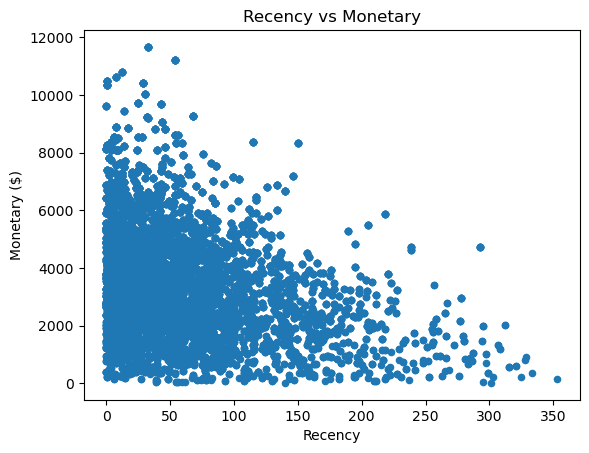

In [72]:
#The chart shows that customers who purchased recently generated more revenue than customers who visited long time ago. Customers from recent past (50-100) days generated a moderate revenue. Customers who visited 200 days ago generated a low revenue.

plt.figure(figsize=(8,7))
cust_trans_rfm.plot.scatter(x='recency' , y='monetary')
plt.xlabel('Recency')
plt.ylabel('Monetary ($)')
plt.title('Recency vs Monetary')
plt.show()

<Figure size 800x700 with 0 Axes>

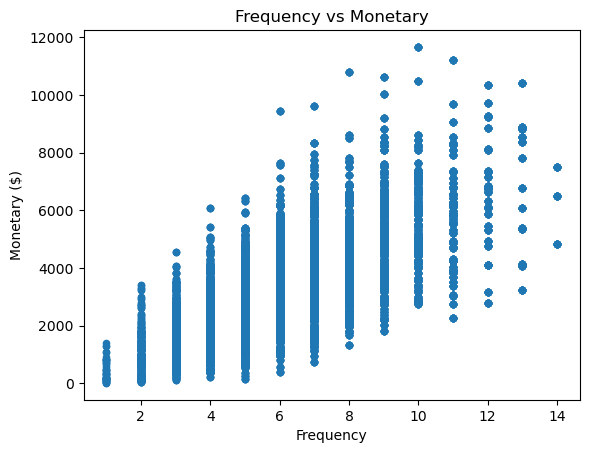

In [79]:
plt.figure(figsize=(8,7))
cust_trans_rfm.plot.scatter(x='frequency' , y='monetary')
plt.xlabel('Frequency')
plt.ylabel('Monetary ($)')
plt.title('Frequency vs Monetary')
plt.show()